In [1]:
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
import datetime
import copy

In [2]:
db = sqlalchemy.engine.url.URL(drivername='mysql',
                            host='127.0.0.1',
                            database='sherman_1',
                            query={'read_default_file': '~/.my.cnf', 'charset':'utf8'})
engine = sqlalchemy.create_engine(db)

In [3]:
df = pd.read_sql('''
    SELECT * FROM sherman_1.plugin_device_usage;
''' ,engine)

In [4]:
df

,_id,timestamp,device_id,double_elapsed_device_on,double_elapsed_device_off,elapsed_device_on,elapsed_device_off
0,16720,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,0.0,0.0,0.000000,741014.879227
1,16721,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,0.0,0.0,16844.935894,0.000000
2,16722,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,0.0,0.0,0.000000,39441.437960
3,16723,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,0.0,0.0,14067.272902,0.000000
4,16724,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,0.0,0.0,0.000000,57318.086147
...,...,...,...,...,...,...,...
228362,245082,1.673474e+12,890fa6c5-0126-4953-8bb8-808dffcb55c8,0.0,0.0,0.000000,654964.899063
228363,245083,1.673473e+12,41646f47-46d6-4ea7-90fd-0b6afaea3d64,0.0,0.0,130708.126068,0.000000
228364,245084,1.673474e+12,30ca0662-67d1-42d6-9610-d435e60a6a79,0.0,0.0,426922.951937,0.000000
228365,245085,1.673474e+12,30ca0662-67d1-42d6-9610-d435e60a6a79,0.0,0.0,0.000000,71758.393049


In [5]:
df['date'] = pd.to_datetime(df['timestamp'],unit='ms').dt.date

In [6]:
df_less = df[['device_id','date','elapsed_device_on','elapsed_device_off']]

In [7]:
df_output = df_less.groupby(['device_id','date']).sum()
df_output['elapsed_device_on'] = df_output['elapsed_device_on'].apply(lambda x: x/1000)
df_output['elapsed_device_off'] = df_output['elapsed_device_off'].apply(lambda x: x/1000)
df_output = df_output.reset_index()
df_output

,device_id,date,elapsed_device_on,elapsed_device_off
0,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,2059.867325,9058.977986
1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,5478.438835,79157.384791
2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,7987.285942,80162.947736
3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,9316.175104,77363.962594
4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,13422.878653,73212.289174
...,...,...,...,...
2695,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,10918.917861,74248.107077
2696,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,11998.857603,63072.433905
2697,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-31,31610.016154,48664.681181
2698,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2023-01-01,8131.785642,73785.401312


In [8]:
df_output.to_csv("device_usage_cleaned.csv", index = False)

# filter 1-28

In [9]:
def find_first_day(device_id, df_cleaned):
    df_target = df_cleaned[df_cleaned['device_id']==device_id]
    return min(df_target['date'])

In [10]:
def get_1_to_28(df_cleaned):
    first_day = {device_id:find_first_day(device_id, df_cleaned) 
                 for device_id in set(df_cleaned['device_id'].tolist())
                if find_first_day(device_id, df_cleaned)>=datetime.date(year=2022,month=11,day=11)}
    df_cleaned = df_cleaned[df_cleaned['device_id'].isin(first_day)]
    df_cleaned['day'] = df_cleaned.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)
    df_cleaned = df_cleaned[df_cleaned['day']<=28]
    return df_cleaned

In [11]:
df_cleaned_1_28 = get_1_to_28(df_output)
df_cleaned_1_28

<ipython-input-10-81973113a098>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['day'] = df_cleaned.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)


,device_id,date,elapsed_device_on,elapsed_device_off,day
0,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,2059.867325,9058.977986,1
1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,5478.438835,79157.384791,2
2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,7987.285942,80162.947736,3
3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,9316.175104,77363.962594,4
4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,13422.878653,73212.289174,5
...,...,...,...,...,...
2695,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,10918.917861,74248.107077,23
2696,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,11998.857603,63072.433905,24
2697,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-31,31610.016154,48664.681181,25
2698,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2023-01-01,8131.785642,73785.401312,26


# lineplot

In [12]:
df_plot = copy.deepcopy(df_cleaned_1_28)
df_plot = df_plot[['elapsed_device_on','elapsed_device_off','day']]
df_plot = df_plot.groupby('day').mean()
df_plot = df_plot.reset_index()
df_plot


,day,elapsed_device_on,elapsed_device_off
0,1,6275.198024,13797.946793
1,2,17701.784381,61969.812913
2,3,17937.932231,64472.587363
3,4,18312.036898,61294.469200
4,5,15969.729044,62402.577173
5,6,17650.349181,62433.736308
6,7,18527.792646,60017.899223
7,8,19096.638475,61383.673864
8,9,19104.618164,63534.388475
9,10,18011.728280,61983.758395


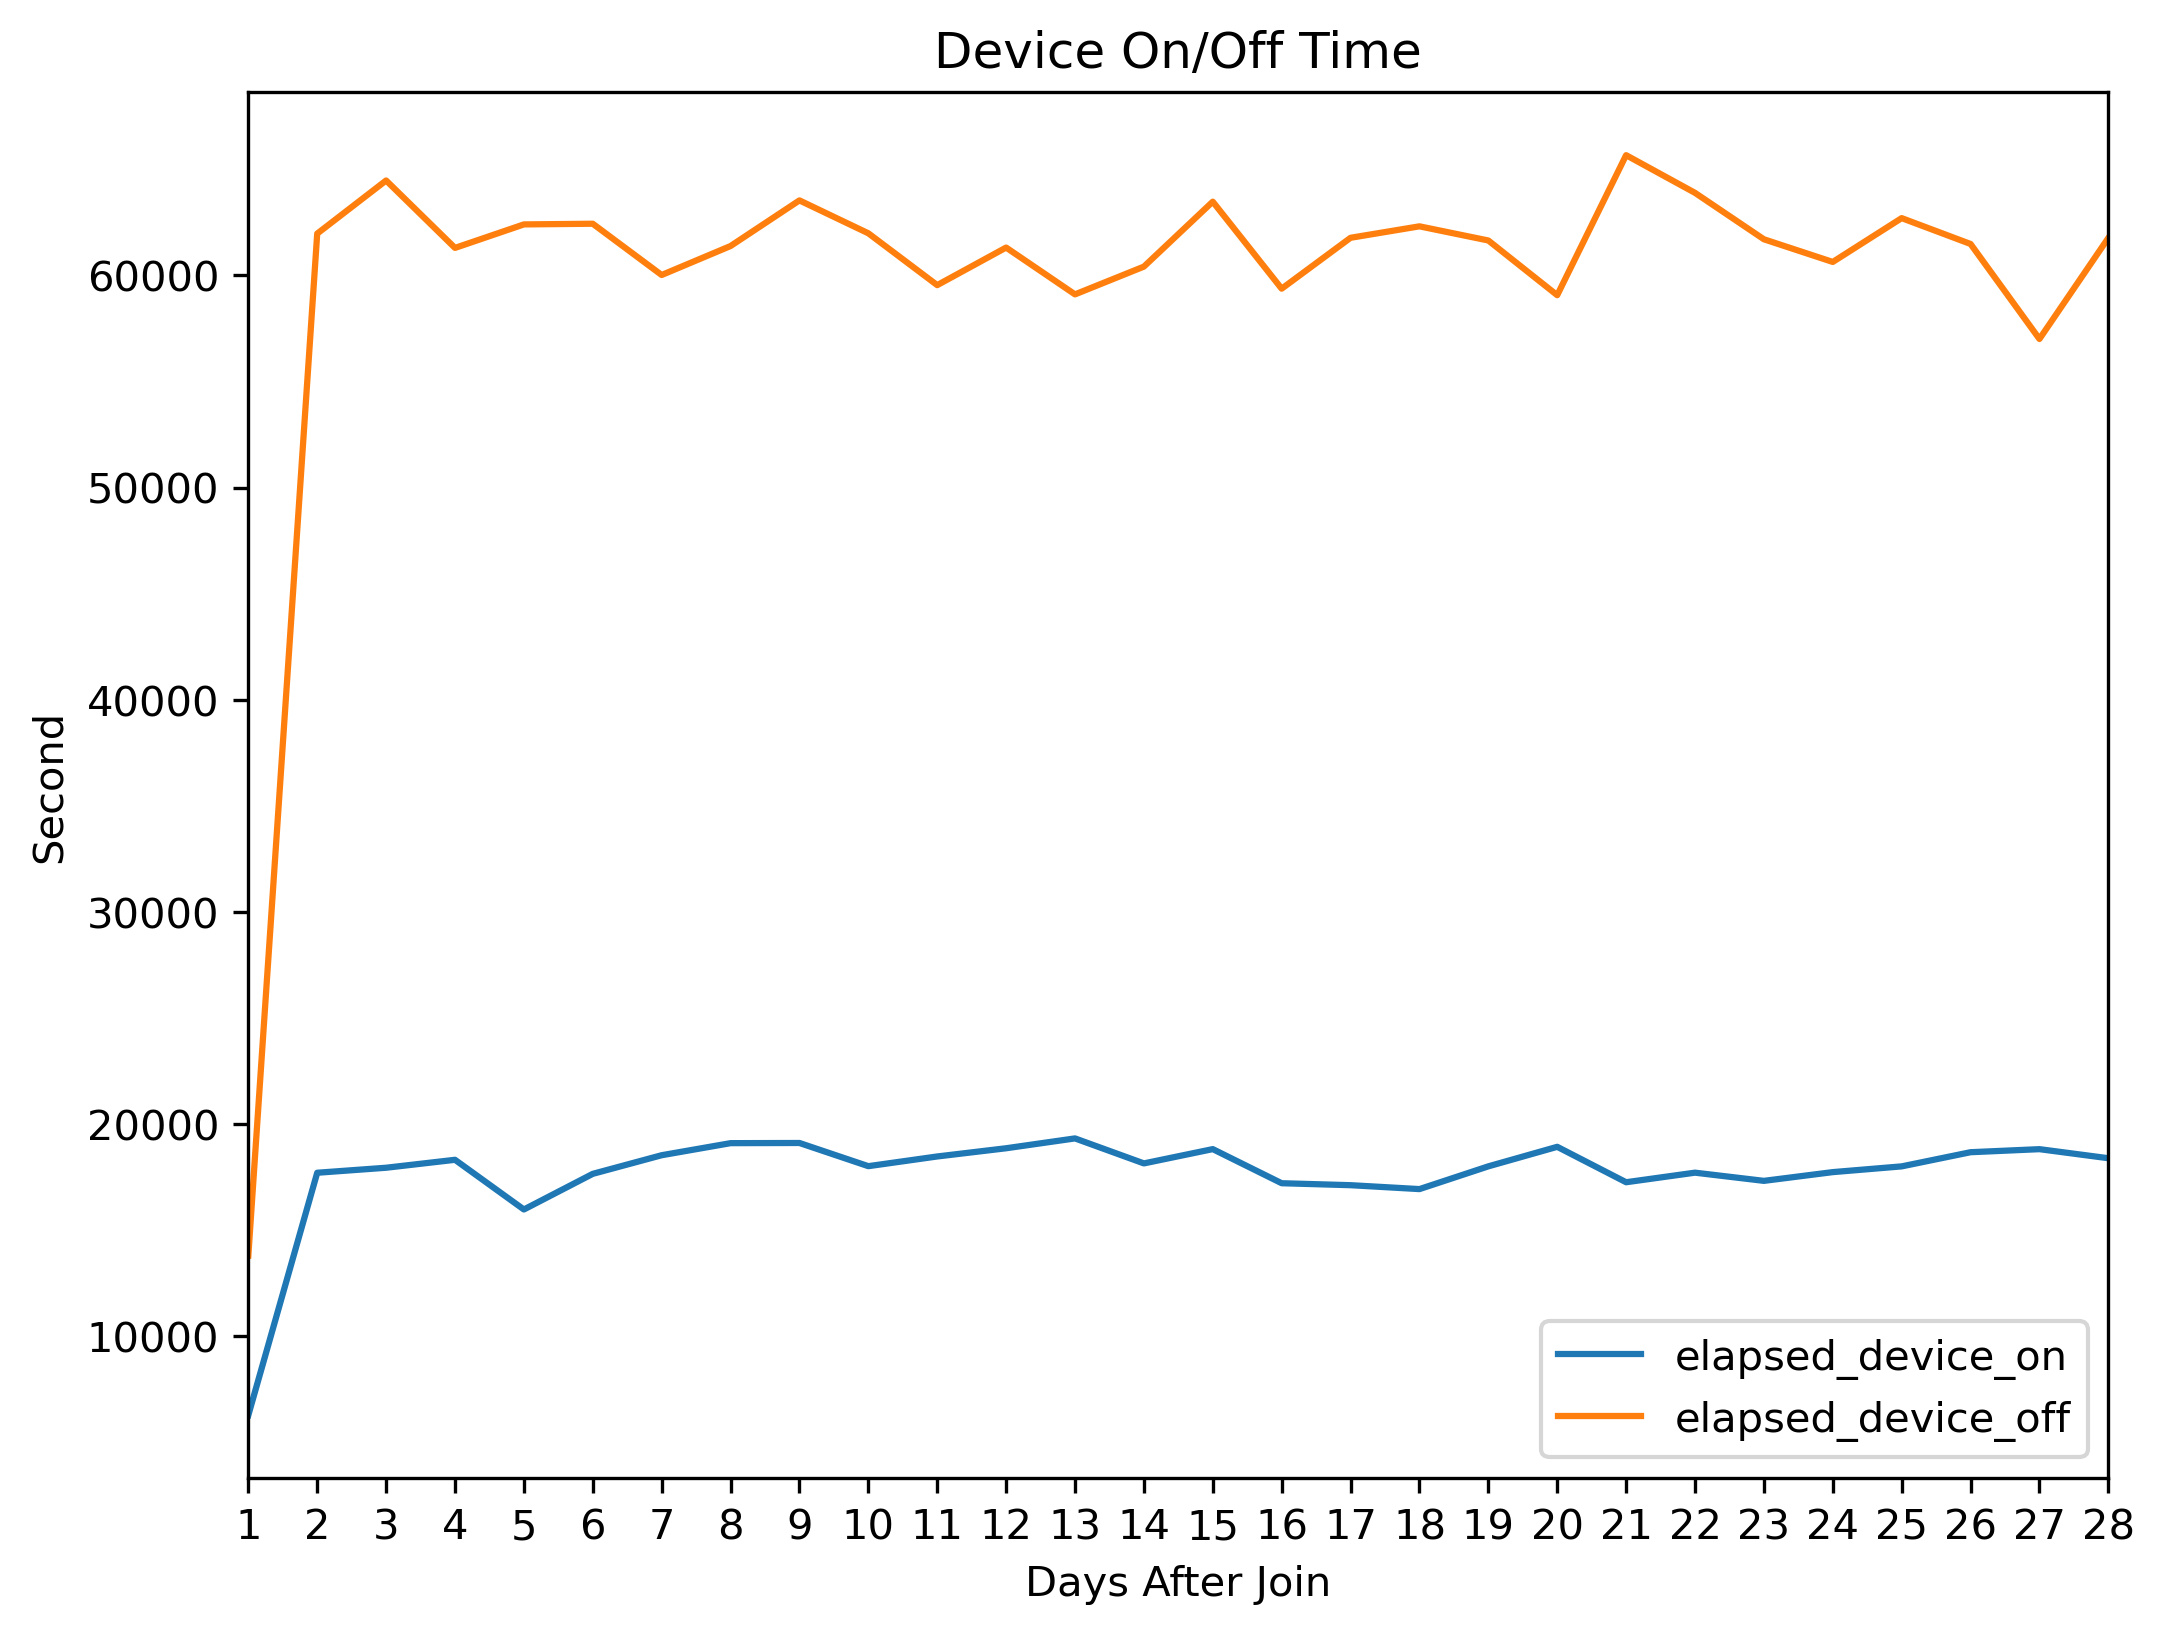

In [13]:
plt.figure(figsize=(8, 6), dpi=300)
for feature in ['elapsed_device_on','elapsed_device_off']:
    x = [i+1 for i in range(28)]
    y = df_plot[feature].tolist()
    plt.plot(x,y,label = feature)
plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Device On/Off Time")
plt.xlabel("Days After Join")
plt.ylabel('Second')
plt.legend()
plt.show()

# group plot

In [14]:
df_id = pd.read_csv("/data/meditation/majid/tables/id.csv")
df_id = df_id.drop_duplicates('study_id')
df_id = df_id.drop('id', axis = 1)
df_id.columns = ['device_id','Study ID']

df_group = pd.read_csv('/data/meditation/majid/surveys/0.csv', skiprows=[1,2])[['Study ID','Group']]
df_group = df_id.merge(df_group, on = 'Study ID', how = 'left')
df_group

,device_id,Study ID,Group
0,4a23c5dc-9a50-4d46-a12d-dd94ee98270f,8415477,Experimental Condition
1,f3845ba4-8702-42cf-a14f-051c46f66b61,15027959,Active Control
2,ae02314b-a607-41b9-9507-28ffa1babed7,73386307,Active Control
3,b460f89e-fd76-46ff-a960-989d74fcb66a,87785016,Active Control
4,e5048fab-dc20-4d99-8cea-220a5a2750e0,14851895,Passive Control
...,...,...,...
64,780c9b18-72d3-4714-858d-3c91b3719155,21788465,Active Control
65,a1118578-bbb4-47ef-b784-7d5bd09ad8b5,7389236,Passive Control
66,00e17b8a-4b0f-4230-bd26-3df2853e8916,69546645,Experimental Condition
67,029e57cb-fa0d-479d-abd2-9cb5745f219d,72690342,Passive Control


In [15]:
df_plot = copy.deepcopy(df_cleaned_1_28)
df_plot = df_plot.merge(df_group[['device_id','Group']], on = 'device_id', how = 'left')
df_plot = df_plot[['elapsed_device_on','elapsed_device_off','day','Group']]
df_plot = df_plot.groupby(['Group','day']).mean()
df_plot = df_plot.reset_index()
df_plot


,Group,day,elapsed_device_on,elapsed_device_off
0,Active Control,1,7001.634320,16550.196293
1,Active Control,2,16408.808988,66688.211597
2,Active Control,3,18263.372643,68317.956400
3,Active Control,4,17481.242905,67562.984839
4,Active Control,5,17422.975933,62975.680546
...,...,...,...,...
79,Passive Control,24,23846.370941,57434.384630
80,Passive Control,25,22517.128004,54247.811389
81,Passive Control,26,24611.829344,53791.839220
82,Passive Control,27,25327.446065,49235.000687


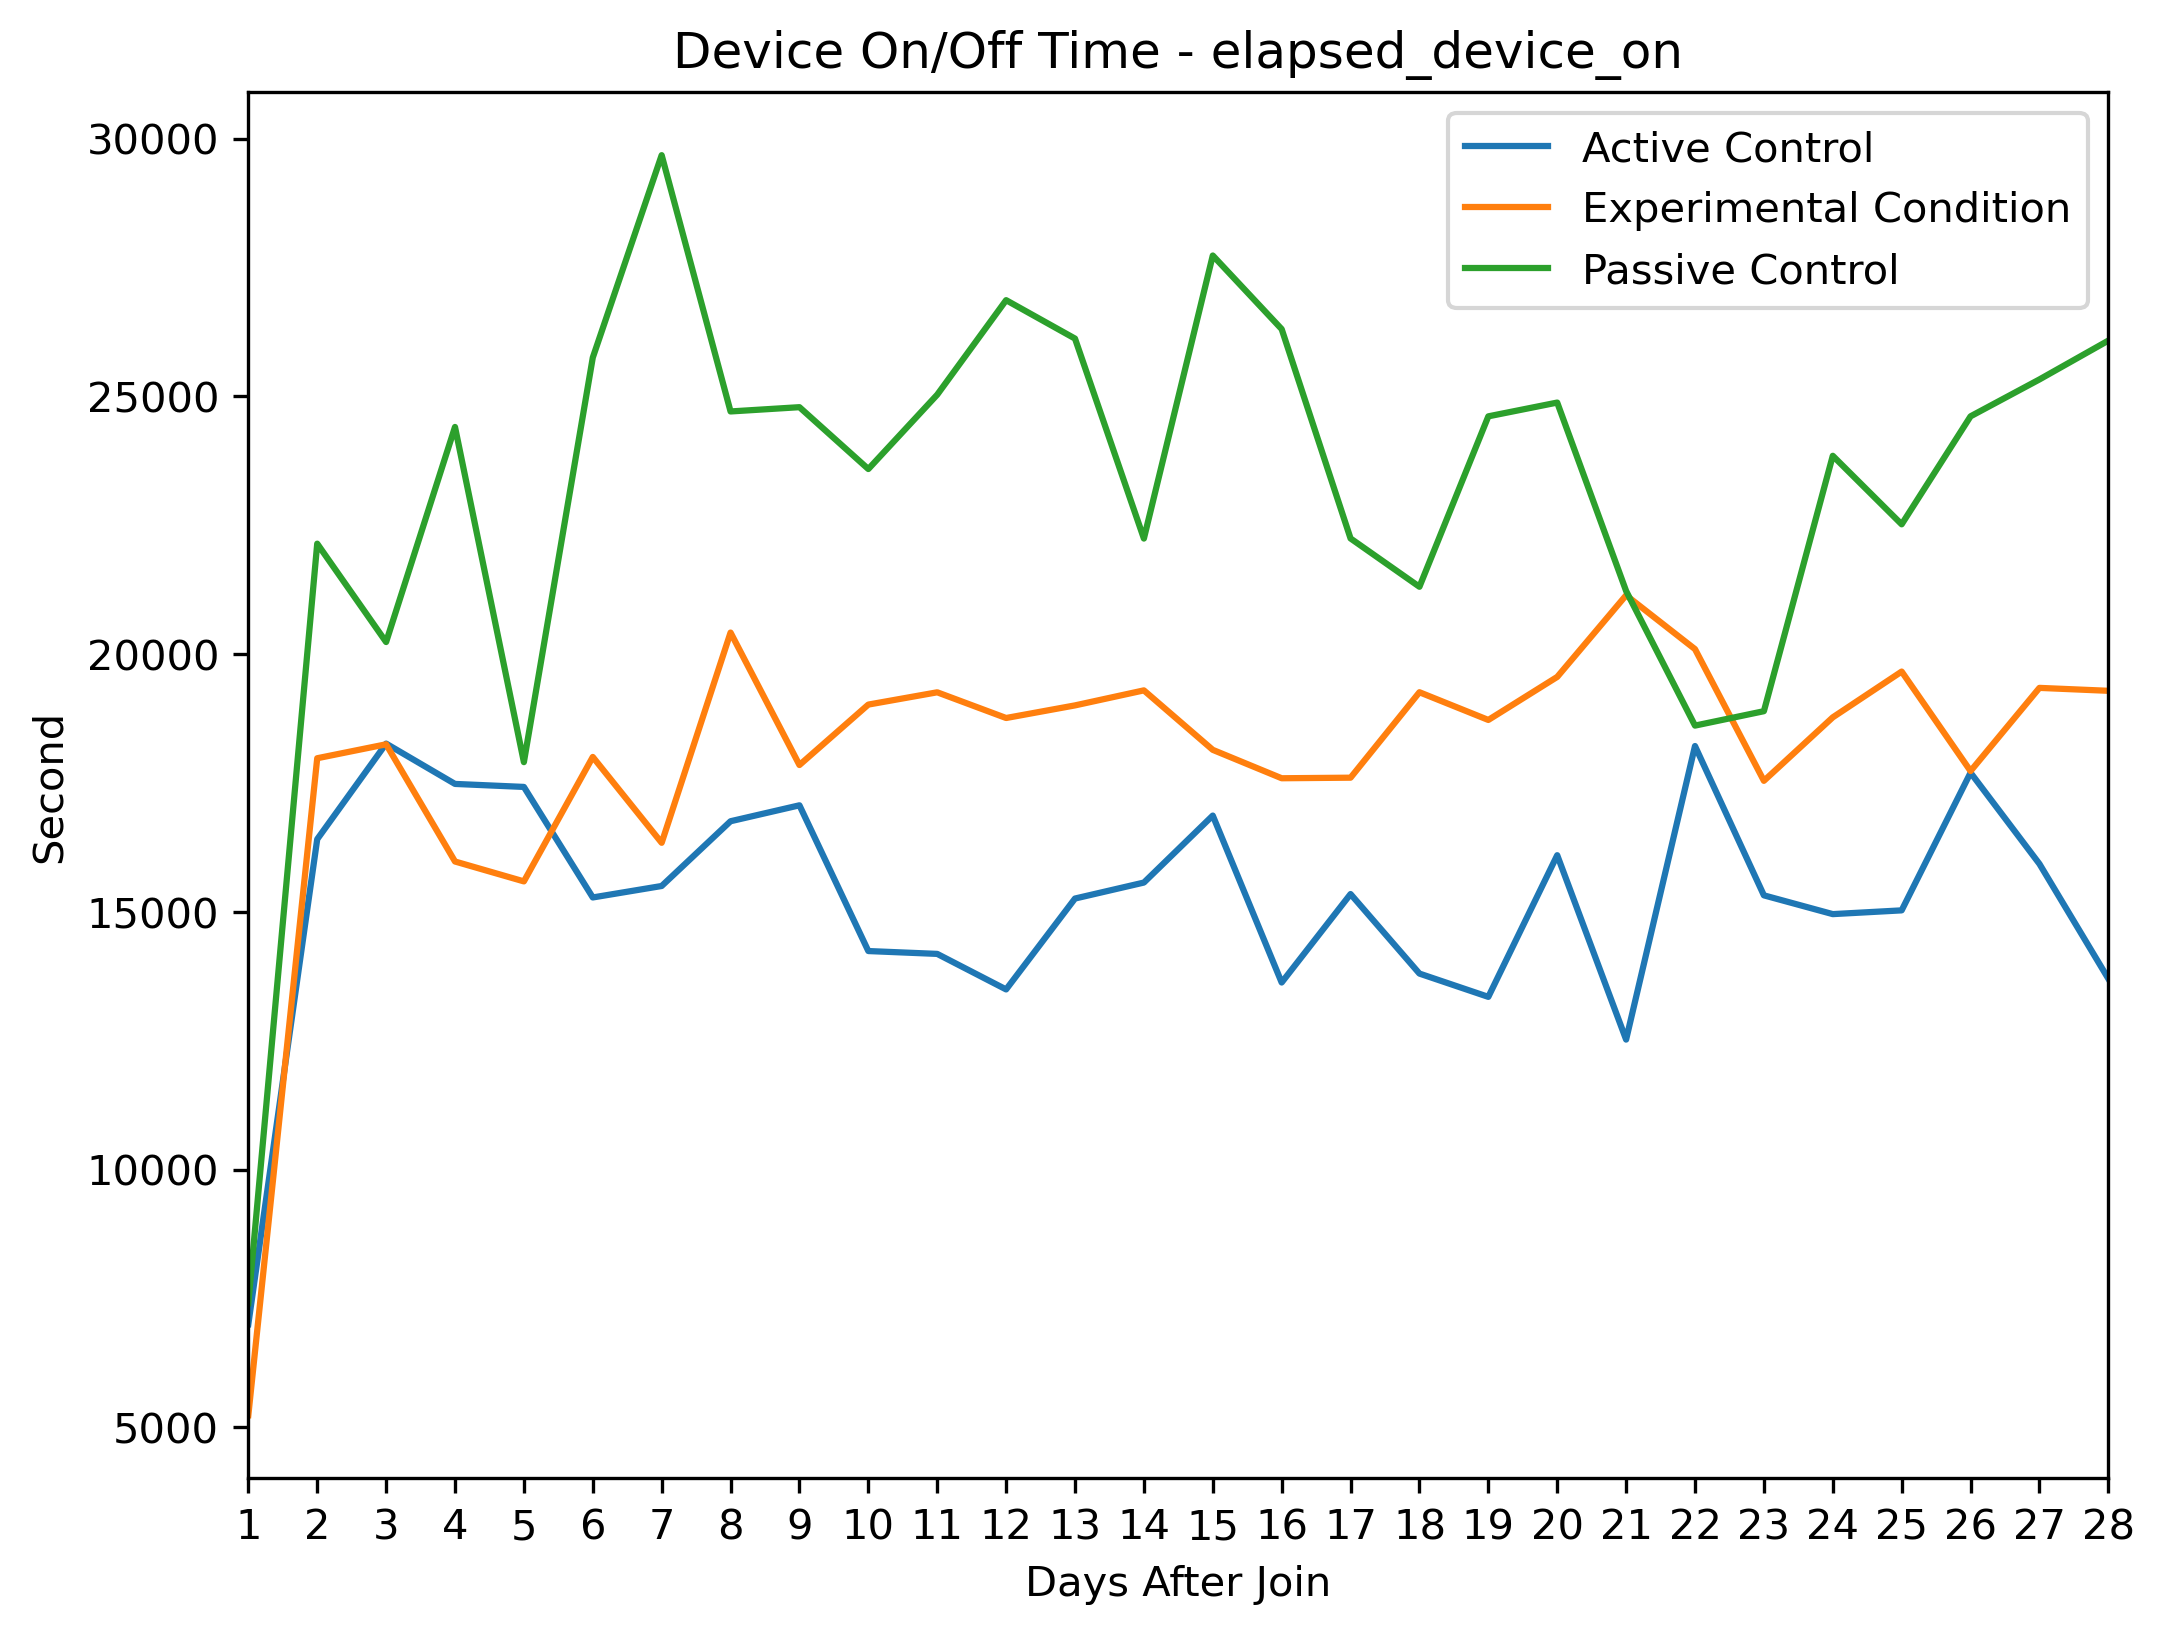

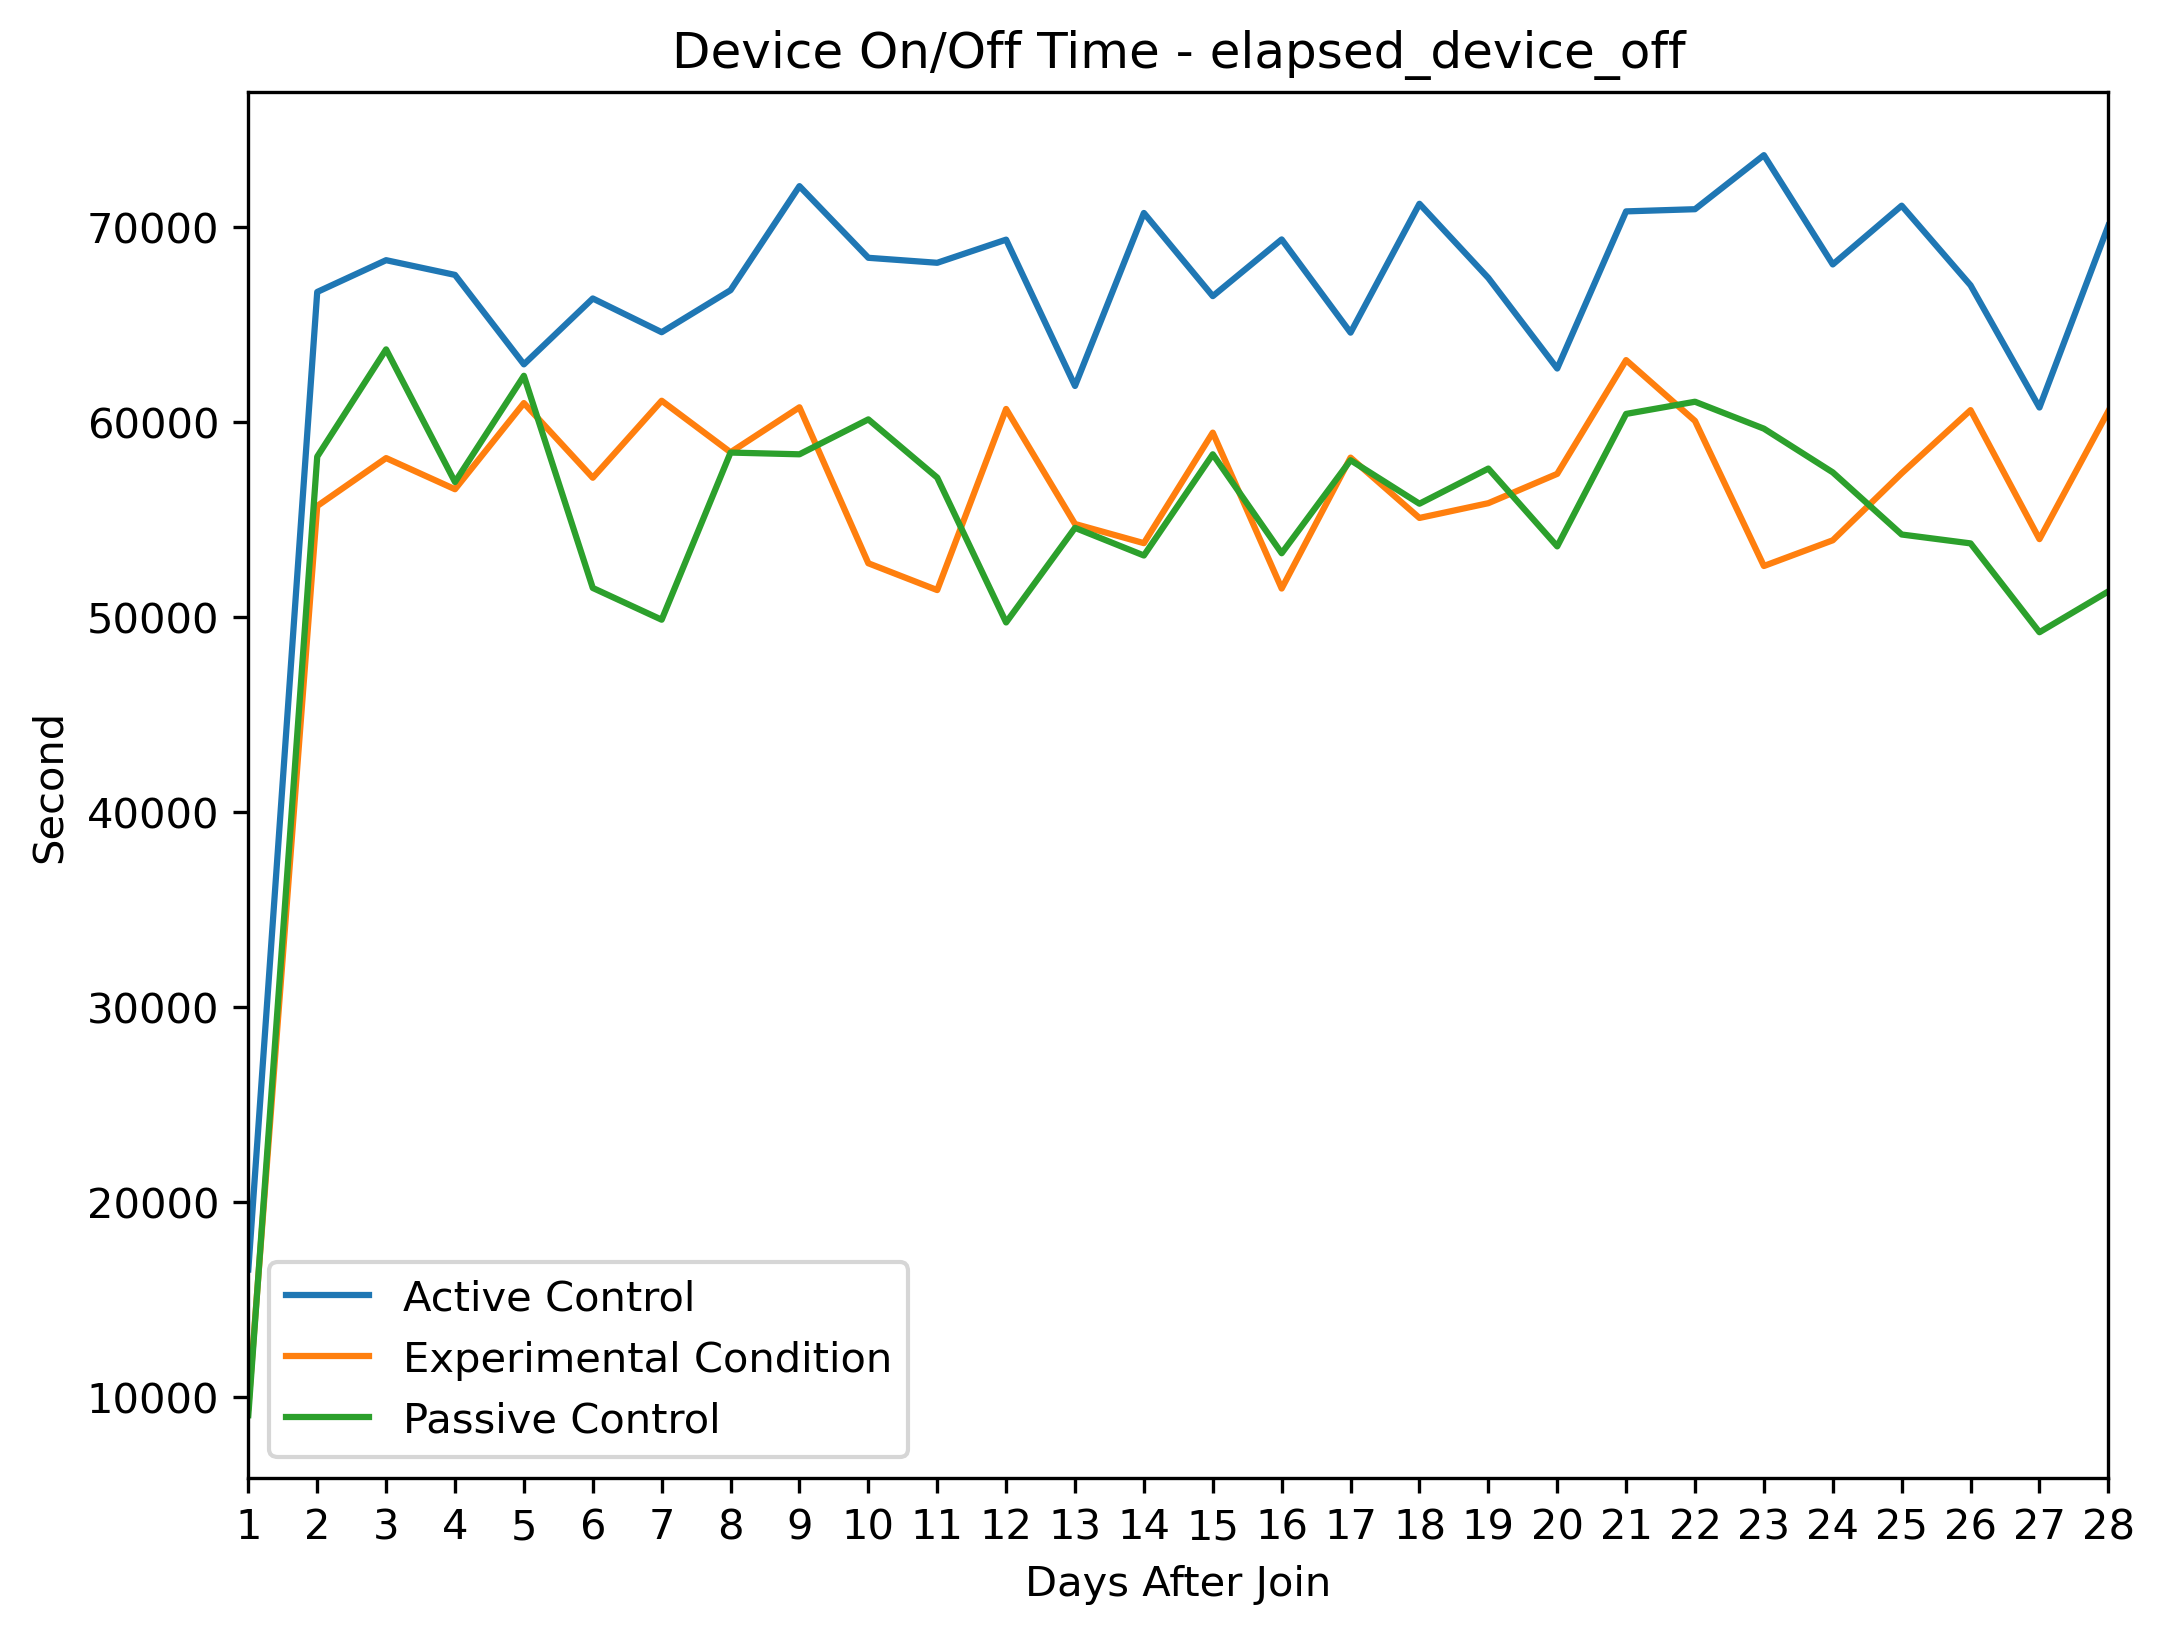

In [16]:
for feature in ['elapsed_device_on','elapsed_device_off']:
    plt.figure(figsize=(8, 6), dpi=300)
    for group in ['Active Control', 'Experimental Condition', 'Passive Control']:
        df_target = df_plot[df_plot['Group']==group]
        x = [i+1 for i in range(28)]
        y = df_target[feature].tolist()
        plt.plot(x,y,label = group)
    plt.xlim(1,28)
    plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
    plt.title("Device On/Off Time - "+feature)
    plt.xlabel("Days After Join")
    plt.ylabel('Second')
    plt.legend()
    plt.show()